pytorch实现猫咪分类

In [ ]:
import torch
import torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from tensorboardX import SummaryWriter
# from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as TF
import torch.nn as nn
from tqdm import tqdm
import cv2
import random

c:\Users\Administrator\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# （一）准备数据

1. 制作数据清单
2. 构建DataLoader(Dataset -> DataLoader)


In [40]:
#数据集划分train：valid = 8 ：2
with open('./train_list.txt', 'r') as f:
    image_list = f.readlines()
random.shuffle(image_list)
cut = int(len(image_list) * 0.8)
train_list = image_list[:cut]
valid_list = image_list[cut:]
      
#创建train_list.txt
with open('train.txt', 'w') as f:
    for path in train_list:
        img_paths = path.split()[0]
        img_label = path.split()[1]
        f.write(img_paths + ',' + img_label + '\n')

#创建valid_list.txt
with open('test.txt', 'w') as f:
    for path in valid_list:
        img_paths = path.split()[0]
        img_label = path.split()[1]
        f.write(img_paths + ',' + img_label + '\n')

In [2]:
#可自调参数
total_epochs = 10
lr = 0.0001
weight_decay = 5e-4
batch_size_train = 32
batch_size_test = 32
# 优化方法
optimizer = "AdamW"

In [4]:
# 构造dataloader
class Dataset(Dataset):
    
    def __init__(self, datafile):
        datalist = open(datafile, 'r')
        self.image_files = datalist.readlines()

    def __getitem__(self, index):
        # 获取第index的数据； 替换其中的换行符（\n）;利用split()进行切分，切分依据是'    '。
        split_images_dir = self.image_files[index].replace('\n','').split(',')
        # 前一步是将str切分为list，第一个数据是path，第二个数据是label，注意都是str类型
        img_path = split_images_dir[0]
        label = split_images_dir[1]
        # 将str类型转为int类型，在到tensor类
        label = int(label)
        label = torch.tensor(label)

        # 图像转为tensor的方法一：
        # 读取图像(Image类)，参数：图像path；convert是将图像转为什么形式（原来是BGR的形式，转为RGB形式）
        img = Image.open(img_path).convert('RGB')
        # 将图像重新调整大小为224×224，Image.BILINEAR指resize的方法
        img = img.resize((224, 224), Image.BILINEAR)
        # 将Image类转为tensor类
        img = TF.to_tensor(img)
       
        return img, label
    def __len__(self):
        return len(self.image_files)
    

# （二）搭建网络
```任务一：搭建自己的神经网络MyNet()
```

In [6]:
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision
from torch.utils.data import WeightedRandomSampler
from torchvision import transforms
from tqdm import tqdm

loss = None  # 可以避免警告，不用这句话也行


def train(model1, device, dataloader, optimizer1, epoch1):
    global loss
    model1.train()  # 设置模型为训练模式
    correct = 0
    all_len = 0
    dataloader = tqdm(dataloader)
    dataloader.set_description('epoch: {}/{}'.format(epoch1, total_epochs))
    for batch_id, data in enumerate(dataloader):
        x = data[0]
        y = data[1]
        optimizer1.zero_grad()  # 梯度清零
        output = model1(x)  # 模型前向传播
        pred = output.max(1, keepdim=True)[1]  # 获取预测结果
        correct += pred.eq(y.view_as(pred)).sum().item()  # 统计预测正确的数量
        all_len += len(x)  # 统计样本数量
        loss = nn.CrossEntropyLoss()(output, y)  # 计算损失
        loss.backward()  # 反向传播，计算梯度
        optimizer1.step()  # 更新模型参数
    print(f"第 {epoch1} 次训练的Train准确率：{100. * correct / all_len:.2f}%")  # 打印训练准确率
        
def vaild(model, device, dataloader):
    model.eval()  # 设置模型为评估模式
    global loss
    correct = 0
    test_loss = 0
    all_len = 0
    with torch.no_grad():
        for batch_id, data in enumerate(dataloader):
            x = data[0]
            y = data[1]
            output = model(x)  # 模型前向传播
            loss = nn.CrossEntropyLoss()(output, y)  # 计算损失
            test_loss += loss.item()  # 累计测试损失
            pred = output.argmax(dim=1, keepdim=True)  # 获取预测结果
            correct += pred.eq(y.view_as(pred)).sum().item()  # 统计预测正确的数量
            all_len += len(x)  # 统计样本数量
    print(f"Test 准确率：{100. * correct / all_len:.2f}%")  # 打印测试准确率
    return 100. * correct / all_len  # 返回测试准确率

# 构造dataloader
class Dataset(Dataset):
    
    def __init__(self, datafile):
        datalist = open(datafile, 'r')
        self.image_files = datalist.readlines()

    def __getitem__(self, index):
        # 获取第index的数据； 替换其中的换行符（\n）;利用split()进行切分，切分依据是'    '。
        split_images_dir = self.image_files[index].replace('\n','').split(',')
        # 前一步是将str切分为list，第一个数据是path，第二个数据是label，注意都是str类型
        img_path = split_images_dir[0]
        label = split_images_dir[1]
        # 将str类型转为int类型，在到tensor类
        label = int(label)
        label = torch.tensor(label)

        # 图像转为tensor的方法一：
        # 读取图像(Image类)，参数：图像path；convert是将图像转为什么形式（原来是BGR的形式，转为RGB形式）
        img = Image.open(img_path).convert('RGB')
        # 将图像重新调整大小为224×224，Image.BILINEAR指resize的方法
        img = img.resize((224, 224), Image.BILINEAR)
        # 将Image类转为tensor类
        img = TF.to_tensor(img)
       
        return img, label
    def __len__(self):
        return len(self.image_files)


# （三）训练CNN（ResNet）模型

In [47]:

if __name__ == '__main__':

    DEVICE = torch.device('cpu')
    LR = 0.0001  # 学习率
    EPOCH = 30  # 训练轮数
    total_epochs = EPOCH
    BTACH_SIZE = 32  # 批量大小

    train_dataset = Dataset( datafile = './train.txt')
    train_loader = DataLoader(dataset=train_dataset,
                        batch_size= 16,
                        shuffle=True,
                        drop_last=True,
                        num_workers=0)

    test_dataset = Dataset( datafile = './test.txt')
    test_loader = DataLoader(dataset=test_dataset,
                        batch_size= 16,
                        shuffle=False,
                        drop_last=False,
                        num_workers=0)

    example = enumerate(train_loader)
    itmes, (img, label) = next(example)
    print('img-->>      shape:{}   max:{}   min:{}'.format(img.shape, img.max(), img.min()) )
    print('label-->>    shape:{}   max:{}   min:{}'.format(label.shape, label.max(), label.min()) )

    # 加载预训练的 ResNet-50 模型，并替换掉最后一层全连接层（fc），使其适应当前任务（共12个类别）。
    model_1 = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')
    model_1.fc = nn.Sequential(nn.Linear(2048, 12))

    # 设置模型为训练模式
    model_1.to(DEVICE)
    # 通过 optim.SGD(model_1.parameters(), lr=LR, momentum=0.9) 定义了 SGD 优化器。这里的 model_1.parameters() 表示优化器需要更新的模型参数，lr=LR 表示学习率为 LR，momentum=0.9 表示使用动量（momentum）参数为0.9。
    optimizer = optim.SGD(model_1.parameters(), lr=LR, momentum=0.9)
    # 设置初始的最高准确率为 5.0，并初始化最优模型。
    max_accuracy = 5.0
    # 最优模型全局变量
    best_model = None
    
    for epoch in range(1, EPOCH + 1):
        train(model_1, DEVICE, train_loader, optimizer, epoch)
        accu = vaild(model_1, DEVICE, test_loader)
        # 保存准确率最高的模型
        if accu > max_accuracy:
            max_accuracy = accu
            best_model = model_1.state_dict()  # 或者使用 torch.save() 保存整个模型
    # 打印最高准确率
    print("最高成功率： ", max_accuracy)
    # 保存最优模型
    torch.save(best_model, fr"./best_model_train.pth")

img-->>      shape:torch.Size([16, 3, 224, 224])   max:1.0   min:0.0
label-->>    shape:torch.Size([16])   max:10   min:0


epoch: 1/30: 100%|██████████| 108/108 [06:33<00:00,  3.64s/it]


第 1 次训练的Train准确率：11.00%
Test 准确率：22.22%


epoch: 2/30: 100%|██████████| 108/108 [07:04<00:00,  3.93s/it]


第 2 次训练的Train准确率：30.73%
Test 准确率：47.69%


epoch: 3/30: 100%|██████████| 108/108 [09:16<00:00,  5.15s/it]


第 3 次训练的Train准确率：52.20%
Test 准确率：62.04%


epoch: 4/30: 100%|██████████| 108/108 [08:43<00:00,  4.84s/it]


第 4 次训练的Train准确率：65.10%
Test 准确率：70.37%


epoch: 5/30: 100%|██████████| 108/108 [07:53<00:00,  4.38s/it]


第 5 次训练的Train准确率：69.68%
Test 准确率：76.16%


epoch: 6/30: 100%|██████████| 108/108 [07:52<00:00,  4.38s/it]


第 6 次训练的Train准确率：74.94%
Test 准确率：80.79%


epoch: 7/30: 100%|██████████| 108/108 [07:50<00:00,  4.36s/it]


第 7 次训练的Train准确率：78.53%
Test 准确率：82.64%


epoch: 8/30: 100%|██████████| 108/108 [07:50<00:00,  4.36s/it]


第 8 次训练的Train准确率：82.47%
Test 准确率：83.10%


epoch: 9/30: 100%|██████████| 108/108 [07:49<00:00,  4.34s/it]


第 9 次训练的Train准确率：83.28%
Test 准确率：86.34%


epoch: 10/30: 100%|██████████| 108/108 [07:48<00:00,  4.34s/it]


第 10 次训练的Train准确率：84.61%
Test 准确率：87.27%


epoch: 11/30: 100%|██████████| 108/108 [07:49<00:00,  4.34s/it]


第 11 次训练的Train准确率：86.46%
Test 准确率：87.50%


epoch: 12/30: 100%|██████████| 108/108 [07:48<00:00,  4.34s/it]


第 12 次训练的Train准确率：86.40%
Test 准确率：87.96%


epoch: 13/30: 100%|██████████| 108/108 [07:49<00:00,  4.35s/it]


第 13 次训练的Train准确率：86.75%
Test 准确率：90.74%


epoch: 14/30: 100%|██████████| 108/108 [06:41<00:00,  3.72s/it]


第 14 次训练的Train准确率：87.96%
Test 准确率：90.51%


epoch: 15/30: 100%|██████████| 108/108 [07:21<00:00,  4.09s/it]


第 15 次训练的Train准确率：87.96%
Test 准确率：90.74%


epoch: 16/30: 100%|██████████| 108/108 [07:29<00:00,  4.16s/it]


第 16 次训练的Train准确率：88.31%
Test 准确率：90.51%


epoch: 17/30: 100%|██████████| 108/108 [07:28<00:00,  4.16s/it]


第 17 次训练的Train准确率：88.89%
Test 准确率：91.44%


epoch: 18/30: 100%|██████████| 108/108 [07:32<00:00,  4.19s/it]


第 18 次训练的Train准确率：89.87%
Test 准确率：91.67%


epoch: 19/30: 100%|██████████| 108/108 [07:32<00:00,  4.19s/it]


第 19 次训练的Train准确率：89.93%
Test 准确率：92.36%


epoch: 20/30: 100%|██████████| 108/108 [07:32<00:00,  4.19s/it]


第 20 次训练的Train准确率：89.81%
Test 准确率：92.82%


epoch: 21/30: 100%|██████████| 108/108 [07:32<00:00,  4.19s/it]


第 21 次训练的Train准确率：89.93%
Test 准确率：92.59%


epoch: 22/30: 100%|██████████| 108/108 [06:53<00:00,  3.82s/it]


第 22 次训练的Train准确率：90.80%
Test 准确率：92.59%


epoch: 23/30: 100%|██████████| 108/108 [07:45<00:00,  4.31s/it]


第 23 次训练的Train准确率：92.01%
Test 准确率：92.36%


epoch: 24/30: 100%|██████████| 108/108 [07:57<00:00,  4.42s/it]


第 24 次训练的Train准确率：92.48%
Test 准确率：92.82%


epoch: 25/30: 100%|██████████| 108/108 [08:05<00:00,  4.50s/it]


第 25 次训练的Train准确率：93.00%
Test 准确率：93.06%


epoch: 26/30: 100%|██████████| 108/108 [08:01<00:00,  4.46s/it]


第 26 次训练的Train准确率：93.11%
Test 准确率：92.82%


epoch: 27/30: 100%|██████████| 108/108 [07:58<00:00,  4.43s/it]


第 27 次训练的Train准确率：93.75%
Test 准确率：92.36%


epoch: 28/30: 100%|██████████| 108/108 [07:55<00:00,  4.40s/it]


第 28 次训练的Train准确率：92.36%
Test 准确率：93.29%


epoch: 29/30: 100%|██████████| 108/108 [07:54<00:00,  4.39s/it]


第 29 次训练的Train准确率：94.04%
Test 准确率：93.29%


epoch: 30/30: 100%|██████████| 108/108 [07:54<00:00,  4.40s/it]


第 30 次训练的Train准确率：93.46%
Test 准确率：93.06%
最高成功率：  93.28703703703704


# 加载最优模型并继续训练

In [8]:
if __name__ == '__main__':
    DEVICE = torch.device('cpu')
    LR = 0.0001  # 学习率
    EPOCH = 30  # 训练轮数
    total_epochs = EPOCH
    BTACH_SIZE = 32  # 批量大小

    train_dataset = Dataset( datafile = './train.txt')
    train_loader = DataLoader(dataset=train_dataset,
                        batch_size= 16,
                        shuffle=True,
                        drop_last=True,
                        num_workers=0)

    test_dataset = Dataset( datafile = './test.txt')
    test_loader = DataLoader(dataset=test_dataset,
                        batch_size= 16,
                        shuffle=False,
                        drop_last=False,
                        num_workers=0)

    example = enumerate(train_loader)
    itmes, (img, label) = next(example)
    print('img-->>      shape:{}   max:{}   min:{}'.format(img.shape, img.max(), img.min()) )
    print('label-->>    shape:{}   max:{}   min:{}'.format(label.shape, label.max(), label.min()) )

    # 加载预训练的 ResNet-50 模型，并替换掉最后一层全连接层（fc），使其适应当前任务（共12个类别）。
    model_1 = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')
    model_1.fc = nn.Sequential(nn.Linear(2048, 12))

    # 设置模型为训练模式
    model_1.to(DEVICE)
    # 通过 optim.SGD(model_1.parameters(), lr=LR, momentum=0.9) 定义了 SGD 优化器。这里的 model_1.parameters() 表示优化器需要更新的模型参数，lr=LR 表示学习率为 LR，momentum=0.9 表示使用动量（momentum）参数为0.9。
    optimizer = optim.SGD(model_1.parameters(), lr=LR, momentum=0.9)

    # 设置初始的最高准确率为 90.0，并初始化最优模型。
    max_accuracy = 5.0
    # 最优模型全局变量
    best_model = None
    
    model_dict = torch.load("./best_model_train.pth")
    model_1.load_state_dict(model_dict)
    
    val_acc = vaild(model_1, DEVICE, test_loader)

    print("acc is: " + str(val_acc))

    for epoch in range(1, EPOCH + 1):
        train(model_1, DEVICE, train_loader, optimizer, epoch)
        accu = vaild(model_1, DEVICE, test_loader)
        # 保存准确率最高的模型
        if accu > max_accuracy:
            max_accuracy = accu
            best_model = model_1.state_dict()  # 或者使用 torch.save() 保存整个模型
    # 打印最高准确率
    print("最高成功率： ", max_accuracy)
    # 保存最优模型
    torch.save(best_model, fr"./best_model_train.pth")

img-->>      shape:torch.Size([16, 3, 224, 224])   max:1.0   min:0.0
label-->>    shape:torch.Size([16])   max:11   min:0
Test 准确率：93.29%
acc is: 93.28703703703704


epoch: 1/30:   7%|▋         | 8/108 [00:38<08:02,  4.82s/it]


KeyboardInterrupt: 

# 模型测试

In [10]:
if __name__ == '__main__':
    EPOCH = 2
    DEVICE = torch.device('cpu')
    LR = 0.0001  # 学习率
    total_epochs = EPOCH
    BTACH_SIZE = 32  # 批量大小

    train_dataset = Dataset( datafile = './train.txt')
    train_loader = DataLoader(dataset=train_dataset,
                        batch_size= 16,
                        shuffle=True,
                        drop_last=True,
                        num_workers=0)

    test_dataset = Dataset( datafile = './test.txt')
    test_loader = DataLoader(dataset=test_dataset,
                        batch_size= 16,
                        shuffle=False,
                        drop_last=False,
                        num_workers=0)

    example = enumerate(train_loader)
    itmes, (img, label) = next(example)
    print('img-->>      shape:{}   max:{}   min:{}'.format(img.shape, img.max(), img.min()) )
    print('label-->>    shape:{}   max:{}   min:{}'.format(label.shape, label.max(), label.min()) )

    # 加载预训练的 ResNet-50 模型，并替换掉最后一层全连接层（fc），使其适应当前任务（共12个类别）。
    model_1 = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')
    model_1.fc = nn.Sequential(nn.Linear(2048, 12))

    # 设置模型为训练模式
    model_1.to(DEVICE)
    # 通过 optim.SGD(model_1.parameters(), lr=LR, momentum=0.9) 定义了 SGD 优化器。这里的 model_1.parameters() 表示优化器需要更新的模型参数，lr=LR 表示学习率为 LR，momentum=0.9 表示使用动量（momentum）参数为0.9。
    optimizer = optim.SGD(model_1.parameters(), lr=LR, momentum=0.9)

    # 设置初始的最高准确率为 90.0，并初始化最优模型。
    max_accuracy = 5.0
    # 最优模型全局变量
    best_model = None
    
    model_dict = torch.load("./best_model_train.pth")
    model_1.load_state_dict(model_dict)
    
    val_acc = vaild(model_1, DEVICE, test_loader)

    print("acc is: " + str(val_acc))
        

img-->>      shape:torch.Size([16, 3, 224, 224])   max:1.0   min:0.0
label-->>    shape:torch.Size([16])   max:11   min:0
Test 准确率：93.29%
acc is: 93.28703703703704


# （四）搭建并训练GAN网络

In [ ]:
train_dataset = Dataset( datafile = './train.txt')
train_loader = DataLoader(dataset=train_dataset,
                        batch_size= 16,
                        shuffle=True,
                        drop_last=True,
                        num_workers=0)

test_dataset = Dataset( datafile = './test.txt')
test_loader = DataLoader(dataset=test_dataset,
                        batch_size= 16,
                        shuffle=False,
                        drop_last=False,
                        num_workers=0)

# 定义数据转换
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
device = torch.device("cuda:0") # ""
batch_size = 32

# 获取一批数据
batch_data, batch_labels = next(iter(train_loader))

# 可视化数据
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.show()

# 随机选择一张图像进行可视化
index = random.randint(0, len(batch_data) - 1)
img, label = batch_data[index], batch_labels[index]
classname = str(label)

# 可视化图像
imshow(img, title=classname)

# 设置随机种子
random.seed(42)
torch.manual_seed(42)

定义生成器和鉴别器，并将它们移动到 GPU 上

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_channels=3, img_height=64, img_width=64):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.num_channels = num_channels
        self.img_height = img_height
        self.img_width = img_width

        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, num_channels, 4, 2, 1, bias=False),  # 输出通道数修改为 num_channels
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(256 * 14 * 14 * 4, 12)  # Adjust the output size for 12 classes
        self.fc2 = nn.Linear(256*16, 12)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        if(x.shape[2] == 4):
            x = x.view(32, -1)
            x = self.fc2(x)
        else:
            x = x.view(-1, 256 * 14 * 14 * 4)
            x = self.fc1(x)
        return x


# 实例化生成器和鉴别器，并将它们移动到 GPU 上
generator = Generator(latent_dim=100).to(device)
discriminator = Discriminator().to(device)

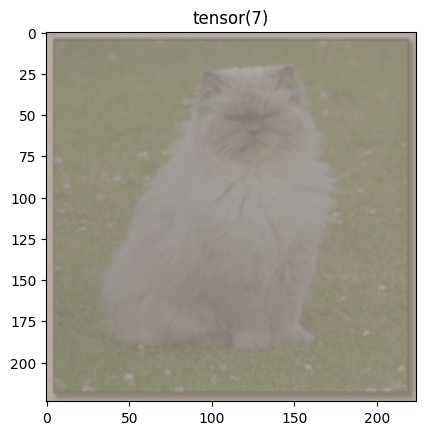

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
Epoch [1/10], Real Loss: 2.3443, Fake Loss: 2.4850
Real Accuracy: 0.2037, Fake Accuracy: 0.1892
Model parameters saved to ./GAN_epoch_1.pth
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
Epoch [2/10], Real Loss: 2.0354, Fake Loss: 2.4849
Real Accuracy: 0.2882, Fake Accuracy: 0.1626
Model pa

In [18]:


# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)

latent_dim = 100
num_epochs = 10
counter = 0

for epoch in range(num_epochs):
    total_real_loss = 0.0
    total_fake_loss = 0.0
    correct_real = 0
    correct_fake = 0

    for real_images, labels in train_loader:
        counter += 1
        print(counter)
        real_images, labels = real_images.cuda(), labels.cuda()

        # 训练鉴别器
        optimizer_d.zero_grad()
        real_outputs = discriminator(real_images)
        real_loss = criterion(real_outputs, labels)
        real_loss.backward()

        # 生成一些假的图像
        fake_noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_images = generator(fake_noise)

        # 假图像的标签（你可以根据需要定义）
        fake_labels = torch.randint(0, 12, (batch_size,)).to(device)

        # 鉴别器对真图像的输出
        real_outputs = discriminator(real_images)
        real_loss = criterion(real_outputs, labels)
        total_real_loss += real_loss.item()

        # 鉴别器对假图像的输出
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = criterion(fake_outputs, fake_labels)
        total_fake_loss += fake_loss.item()

        # 计算准确率
        _, predicted_real = torch.max(real_outputs.data, 1)
        correct_real += (predicted_real == labels).sum().item()

        _, predicted_fake = torch.max(fake_outputs.data, 1)
        correct_fake += (predicted_fake == fake_labels).sum().item()

        optimizer_d.step()

    # 输出每个 epoch 的信息
    avg_real_loss = total_real_loss / len(train_loader)
    avg_fake_loss = total_fake_loss / len(train_loader)
    accuracy_real = correct_real / len(train_loader.dataset)
    accuracy_fake = correct_fake / len(train_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Real Loss: {avg_real_loss:.4f}, Fake Loss: {avg_fake_loss:.4f}')
    print(f'Real Accuracy: {accuracy_real:.4f}, Fake Accuracy: {accuracy_fake:.4f}')

    # 保存模型参数
    checkpoint_path = f'./GAN_epoch_{epoch + 1}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': discriminator.state_dict(),
        'optimizer_state_dict': optimizer_d.state_dict(),
        'loss': avg_real_loss,
    }, checkpoint_path)

    print(f'Model parameters saved to {checkpoint_path}')

# 在验证集上评估模型
discriminator.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = discriminator(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Validation Accuracy: {accuracy * 100:.2f}%')